In [ ]:
#%% Step 0 import necessary packages
import numpy as np;
import pandas as pd;
import os;
import re;
from google.colab import drive;
from collections import Counter;
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score;
from sklearn.linear_model import LogisticRegression;
from sklearn.svm import SVC;
from sklearn.ensemble import RandomForestClassifier;

In [ ]:
!wget https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu -O glove_split.aa
!wget https://docs.google.com/uc?id=1LF2yD2jToXriyD-lsYA5hj03f7J3ZKaY -O glove_split.ab
!wget https://docs.google.com/uc?id=1N1xnxkRyM5Gar7sv4d41alyTL92Iip3f -O glove_split.ac
!cat glove_split.?? > 'glove.6B.300d__50k.txt'

--2021-09-20 11:49:15--  https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving docs.google.com (docs.google.com)... 142.250.188.46, 2607:f8b0:4004:811::200e
Connecting to docs.google.com (docs.google.com)|142.250.188.46|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ngic77reankkbkqu2urpiiuhe1qic9cr/1632138525000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu [following]
--2021-09-20 11:49:20--  https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ngic77reankkbkqu2urpiiuhe1qic9cr/1632138525000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)... 172.217.1.193, 2607:f8b0:4004:801::2001
Connecting to doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)|172.217.1.193|:443...

In [ ]:
!wget 'http://www.aueb.gr/users/ion/data/enron-spam/preprocessed/enron1.tar.gz'
!wget 'http://www.aueb.gr/users/ion/data/enron-spam/preprocessed/enron2.tar.gz'
!wget 'http://www.aueb.gr/users/ion/data/enron-spam/preprocessed/enron3.tar.gz'
!wget 'http://www.aueb.gr/users/ion/data/enron-spam/preprocessed/enron4.tar.gz'
!wget 'http://www.aueb.gr/users/ion/data/enron-spam/preprocessed/enron5.tar.gz'
!wget 'http://www.aueb.gr/users/ion/data/enron-spam/preprocessed/enron6.tar.gz'

In [ ]:
!tar -xzf enron1.tar.gz
!tar -xzf enron2.tar.gz
!tar -xzf enron3.tar.gz
!tar -xzf enron4.tar.gz
!tar -xzf enron5.tar.gz
!tar -xzf enron6.tar.gz

In [ ]:
!pwd

/content


In [ ]:
!ls

enron1	       enron3.tar.gz  enron6		      glove_split.ac
enron1.tar.gz  enron4	      enron6.tar.gz	      sample_data
enron2	       enron4.tar.gz  glove.6B.300d__50k.txt
enron2.tar.gz  enron5	      glove_split.aa
enron3	       enron5.tar.gz  glove_split.ab


In [ ]:
a#%% 0. import packages
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

from keras.layers import Dense, LSTM, Flatten, Embedding
from keras.utils import to_categorical
from keras.backend import clear_session

from collections import Counter
import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from string import punctuation

In [ ]:
os.getcwd()

'/content'

In [ ]:
#%% 1. load and preprocess data

def pre_process(directory):
    dirs = ['spam','ham'];
    emails = [];
    for i in range(2):
      direc = directory + dirs[i] + '/'
      files = os.listdir(direc)
      #print('current location:' + os.getcwd());
      #emails = [direc + email for email in files]
      emails.extend([direc + email for email in files])
    #print(emails);

    # store all the words in all the emails
    words = []
    # store cleaned up emails
    temp_email_text = []
    # store labels (1=spam/ 0= ham)
    labels = []
    hamcounter = 0
    spamcounter = 0

    for email in emails:
        if "ham" in email:
            labels.append(0)
            hamcounter += 1
        else:
            labels.append(1)
            spamcounter += 1
        f = open(email, encoding="utf8", errors='ignore')
        blob = f.read()
        # removing punctuation
        all_text = ''.join([text for text in blob if text not in punctuation])
        all_text = all_text.split('\n')
        all_text = ''.join(all_text)
        temp_text = all_text.split(" ")

        for word in temp_text:
            if word.isalpha():
                temp_text[temp_text.index(word)] = word.lower()

        temp_text = list(filter(None, temp_text))
        temp_text = ' '.join([i for i in temp_text if not i.isdigit()])
        words += temp_text.split(" ")
        temp_email_text.append(temp_text)

    # making a dictionary of all the words
    dictionary = Counter(words)
    del dictionary[""]
    sorted_split_words = sorted(dictionary, key=dictionary.get, reverse=True)
    vocab_to_int = {c: i for i, c in enumerate(sorted_split_words, 1)}

    message_ints = []
    for message in temp_email_text:
        temp_message = message.split(" ")
        message_ints.append([vocab_to_int[i] for i in temp_message])

    seq_length = 3425
    num_messages = len(temp_email_text)
    features = np.zeros([num_messages, seq_length], dtype=int)
    for i, row in enumerate(message_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]

    #print(hamcounter)
    #print(spamcounter)
    return features, np.array(labels), sorted_split_words, temp_email_text

#features1, labels1, sorted_split_words1, email_text1 = pre_process("/enron1/")
features1, labels1, sorted_split_words1, email_text1 = pre_process("enron1/")
features2, labels2, sorted_split_words2, email_text2 = pre_process("enron2/")
features3, labels3, sorted_split_words3, email_text3 = pre_process("enron3/")
features4, labels4, sorted_split_words4, email_text4 = pre_process("enron4/")
features5, labels5, sorted_split_words5, email_text5 = pre_process("enron5/")
features6, labels6, sorted_split_words6, email_text6 = pre_process("enron6/")


In [ ]:
#this part seems unnecesssary at all. Pls just ignore it though it's still here.
#%% 1. load and preprocess data

#len_emails = 33716;
#df = pd.DataFrame(index=[i for i in range(len_emails)],columns=['label','text']);
#df = df.fillna(0);

#files = [[labels1,email_text1],[labels2,email_text2],[labels3,email_text3],[labels4,email_text4],[labels5,email_text5],[labels6,email_text6]];
#length = 0;
#for file in files:
  #df['label'][length:length+len(file[0])] = file[0];
  #df['text'][length:length+len(file[1])] = file[1];
  #length += len(file[0]);
#df

In [ ]:
#%% 2. split training (1-4), testing (5), validation dataset (6)

import itertools

train_email = list(itertools.chain(email_text1, email_text2, email_text3, email_text4))
#train_labels = np.array(list(itertools.chain(labels1, labels2, labels3, labels4)))
train_labels = list(itertools.chain(labels1, labels2, labels3, labels4))
print(len(train_email))

22541


In [ ]:

### DON'T RUN THIS PART. INSTEAD, USE THE ONE BELOW (will explain later)

#%% 3. load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.300d__50k.txt',encoding='utf-8')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))


Loaded 50000 word vectors.


In [ ]:
embeddings_index.get('subject').shape

(300,)

In [ ]:
type(np.array(embeddings_index.get('subject')))

numpy.ndarray

In [ ]:
#%% 3. load the whole embedding into memory

def load_glove(glove_path, embedding_dim):
    with open(glove_path) as f:
        token_ls = [PAD_TOKEN, UNK_TOKEN]
        embedding_ls = [np.zeros(embedding_dim), np.random.rand(embedding_dim)]
        for line in f:
            token, raw_embedding = line.split(maxsplit=1)
            token_ls.append(token)
            embedding = np.array([float(x) for x in raw_embedding.split()])
            embedding_ls.append(embedding)
        embeddings = np.array(embedding_ls)
    return token_ls, embeddings

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
EMBEDDING_DIM=300 # dimension of Glove embeddings
glove_path = "glove.6B.300d__50k.txt"
vocab, embeddings = load_glove(glove_path, EMBEDDING_DIM)
print('Pretrain model generated!');

Pretrain model generated!


In [ ]:
#%% import packages for nn part
!pip install sacremoses

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import pandas as pd
import sacremoses
from torch.utils.data import dataloader, Dataset
from tqdm.auto import tqdm

     |████████████████████████████████| 901kB 28.4MB/s 


In [ ]:
#%% tokenize the text
def tokenize(data, labels, tokenizer, vocab, max_seq_length=150):
    vocab_to_idx = {word: i for i, word in enumerate(vocab)}
    text_data = []
    label_data = []
    for ex in tqdm(data):
        tokenized = tokenizer.tokenize(ex.lower())
        ids = [vocab_to_idx.get(token, 1) for token in tokenized]
        text_data.append(ids)
    return text_data, labels
tokenizer = sacremoses.MosesTokenizer()
train_data_indices, train_labels = tokenize(train_email, train_labels, tokenizer, vocab)
val_data_indices, val_labels = tokenize(email_text5, labels5, tokenizer, vocab)
test_data_indices, test_labels = tokenize(email_text6, labels6, tokenizer, vocab)

In [ ]:
#%%get the dataset (in a form that's interpretable for pytorch)
from torch.utils.data import Dataset

class GetDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list, max_sent_length=128):
        """
        @param data_list: list of data tokens 
        @param target_list: list of data targets 

        """
        self.data_list = data_list;
        self.target_list = target_list;
        self.max_sent_length = max_sent_length;
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key, max_sent_length=None):
        """
        Triggered when you call dataset[i]
        """
        if max_sent_length is None:
            max_sent_length = self.max_sent_length;
        token_idx = self.data_list[key][:max_sent_length];
        label = self.target_list[key];
        return [token_idx, label]

    def spam_collate_func(self,batch):
        """
        Customized function for DataLoader that dynamically pads the batch so that all 
        data have the same length
        """ 
        data_list = [] # store padded sequences
        label_list = []
        max_batch_seq_len = None # the length of longest sequence in batch
                                 # if it is less than self.max_sent_length
                                 # else max_batch_seq_len = self.max_sent_length

        """
          # Pad the sequences in your data 
          # if their length is less than max_batch_seq_len
          # or trim the sequences that are longer than self.max_sent_length
          # return padded data_list and label_list

        """
        label_list = [datum[1] for datum in batch]
        max_batch_seq_len = max(len(datum[0]) for datum in batch)
        if max_batch_seq_len > self.max_sent_length:
            max_batch_seq_len = self.max_sent_length

        for datum in batch:
            padded_vec = np.pad(np.array(datum[0]), 
                                    pad_width=((0,max_batch_seq_len-len(datum[0]))), 
                                    mode="constant", constant_values=0)
            data_list.append(padded_vec)
        data_list = torch.from_numpy(np.array(data_list))
        label_list = torch.LongTensor(label_list)        

        return [data_list, label_list]

BATCH_SIZE = 64
max_sent_length=150
train_dataset = GetDataset(train_data_indices, train_labels, max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=True)

val_dataset = GetDataset(val_data_indices, val_labels, train_dataset.max_sent_length)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

test_dataset = GetDataset(test_data_indices, test_labels, train_dataset.max_sent_length)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)
print('Dataset built successfully!');


Dataset built successfully!


In [ ]:
len(val_data_indices),len(val_labels)

(5175, 5175)

In [ ]:
data_batch, labels = next(iter(train_loader))
print("data batch dimension: ", data_batch.size())
print("data_batch: ", data_batch)
print("labels: ", labels)
embedding_layer = nn.Embedding(embeddings.shape[0], embeddings.shape[1], padding_idx=0)
embedding_layer.weight.data = torch.Tensor(embeddings).float()
temp = embedding_layer(data_batch)
temp

data batch dimension:  torch.Size([64, 150])
data_batch:  tensor([[ 1700,  1938,  1062,  ...,     2,     1,   310],
        [ 1700,  1767,   742,  ...,  1373,    14,    83],
        [ 1700,   630,   636,  ...,     1,    14,   323],
        ...,
        [ 1700, 15001,  3519,  ..., 10110,    50,     5],
        [ 1700, 35927, 19038,  ...,     0,     0,     0],
        [ 1700, 35927, 35927,  ...,     0,     0,     0]])
labels:  tensor([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0])


tensor([[[-0.2184, -0.2812,  0.3738,  ...,  0.0169,  0.1652,  0.1304],
         [ 0.2121,  0.3026,  0.0933,  ...,  0.7090,  0.0328,  0.1230],
         [ 0.4426,  0.3437, -0.2069,  ...,  0.5162, -0.1697, -0.1191],
         ...,
         [ 0.0466,  0.2132, -0.0074,  ...,  0.0091, -0.2099,  0.0539],
         [ 0.5558,  0.6965,  0.4320,  ...,  0.5765,  0.9509,  0.8876],
         [-0.3887, -0.3038,  0.1527,  ..., -0.0185, -0.0993, -0.0053]],

        [[-0.2184, -0.2812,  0.3738,  ...,  0.0169,  0.1652,  0.1304],
         [ 0.3508, -0.2135, -0.0103,  ..., -0.4211, -0.0879,  0.3736],
         [-0.0522, -0.1692,  0.1898,  ...,  0.0850,  0.1513,  0.1694],
         ...,
         [-0.1908, -0.0040, -0.0949,  ..., -0.3659,  0.1502,  0.1124],
         [-0.1826,  0.4985, -0.1639,  ..., -0.2722, -0.1911, -0.0941],
         [-0.2843,  0.0480, -0.1506,  ..., -0.0901,  0.0169,  0.2928]],

        [[-0.2184, -0.2812,  0.3738,  ...,  0.0169,  0.1652,  0.1304],
         [ 0.3563, -0.0457, -0.4918,  ..., -0

In [ ]:
class LSTMclassifier(nn.Module):
  def __init__(self,embeddings,hidden_size,num_layers,num_classes,dropout_rate=0.2):
    super().__init__();
    self.embedding_layer = self.load_pretrained_embeddings(embeddings);
    self.hidden_size = hidden_size;
    self.num_layers = num_layers;
    self.dropout = nn.Dropout(p=dropout_rate);
    self.lstm = nn.LSTM(embeddings.shape[1], hidden_size, num_layers, batch_first=True, dropout=0.3);
    self.relu = nn.ReLU();
    self.clf = nn.Linear(hidden_size,num_classes);
  
  def load_pretrained_embeddings(self, embeddings):
    embedding_layer = nn.Embedding(embeddings.shape[0], embeddings.shape[1], padding_idx=0)
    embedding_layer.weight.data = torch.Tensor(embeddings).float()
    return embedding_layer
  
  def forward(self,input_data):
    batch_size = input_data.size()[0] # inputs : batch_sz, seq_len
    output = self.dropout(self.embedding_layer(input_data));
    #output,_ = self.lstm(output,None);
    output = self.lstm(output, None)[0];
    output = output.mean(1)
    output = self.relu(output)
    #out = self.relu(torch.mean(out,1))
    logits = self.clf(output)
    return logits

In [ ]:
def evaluate(model, dataloader, device):
    model.eval();
    n_correct, n_total = 0,0;
    model.eval();
    with torch.no_grad():
        for (data_batch, batch_labels) in dataloader:
            output = model(data_batch.to(device));
            max_scores, preds = output.max(dim=1);
            n_correct += np.sum(preds.cpu().numpy() == batch_labels.numpy());
            n_total += output.shape[0];
    accuracy = n_correct * 1.0 / n_total;
    return accuracy 

In [ ]:
#%%
## set hyperparameters
hidden_size = 32;
num_layers = 1;
num_classes = 2;
torch.manual_seed(1234); #?

# if cuda exists, use cuda, else run on cpu
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device=torch.device('cpu')

# set and train the model
model = LSTMclassifier(embeddings, hidden_size, num_layers, num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
train_loss_history = [];
val_accuracy_history = [];
best_val_accuracy = 0;
n_no_improve = 0;
es_step_tolerance = 2; #steps tolerant to go before early stop
epochs = 10;
  
for epoch in tqdm(range(epochs)):
    model.train() # this enables regularization, which we don't currently have
    for i, (data_batch, batch_labels) in enumerate(train_loader):
        """
           Code for training lstm
           Keep track of training of for each batch using train_loss_history
        """
        preds = model(data_batch.to(device));
        loss = criterion(preds, batch_labels.to(device));
        loss.backward();
        optimizer.step();
        optimizer.zero_grad();
        train_loss_history.append(loss.item());
        
    # The end of a training epoch 
    cur_val_accuracy = evaluate(model, val_loader, device=device);
    val_accuracy_history.append(cur_val_accuracy);
    print("epoch: {}, val_accuracy: {}".format(epoch+1, cur_val_accuracy));
    if cur_val_accuracy > best_val_accuracy:
        best_val_accuracy = cur_val_accuracy;
        torch.save(model, 'best_model.pt');
        n_no_improve = 0;
    else:
        n_no_improve += 1;

    if n_no_improve > es_step_tolerance:
        print("Early stopped at epoch ",epoch+1)
        break

epoch: 1, val_accuracy: 0.8488888888888889
epoch: 2, val_accuracy: 0.9828019323671497
epoch: 3, val_accuracy: 0.9847342995169082
epoch: 4, val_accuracy: 0.9841545893719806
epoch: 5, val_accuracy: 0.9835748792270531
epoch: 6, val_accuracy: 0.9820289855072464
Early stopped at epoch  6


In [ ]:
model = torch.load('best_model.pt')
test_accuracy = evaluate(model, test_loader, device)


print(test_accuracy)

0.9786666666666667


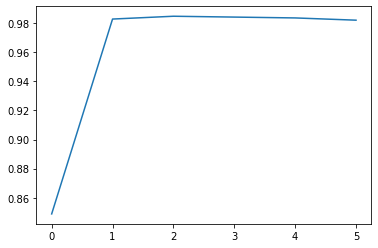

In [ ]:
pd.Series(val_accuracy_history).plot()

In [ ]:
#%% 4. convert text to sequences and create a weight matrix for words in training docs
# prepare tokenizer

max_length = 150

def convert_to_seq(email_text):
  t = Tokenizer()
  t.fit_on_texts(email_text)
  vocab_size = len(t.word_index) + 1
  # integer encode the documents
  encoded_docs = t.texts_to_sequences(email_text)
  # print(encoded_docs)
  # pad documents to a max length of 4 words
  padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
  stop_count = 0
  embedding_matrix = np.zeros((len(train_email), 150, 300))
  for i in range(len(email_text)):
    email_matrix = np.zeros(shape=len(email_text[i]));
    for j in range(len(email_text[i])):
        if stop_count == 0:
          print(type(embeddings_index.get(word)),len(embeddings_index.get(word)));
          stop_count += 1
          continue
        else:
          x = input('what\'s next?');
        embedding_vector = np.array(embeddings_index.get(word),dtype=object);
        if embedding_vector.all() != None:
          email_matrix[j,:,:] = np.array(embedding_vector,dtype=object);
    #email_matrix = np.array(np.array([embeddings_index[word] for word in email_text[i] if word in embeddings_index.keys() and embeddings_index[word][0] != None ]));
    embedding_matrix[i,:,:] = email_matrix;
  
  # for word, i in t.word_index.items():
  #   embedding_vector = embeddings_index.get(word)
  #   if embedding_vector is not None:
  #     embedding_matrix[i] = embedding_vector  

  return vocab_size, embedding_matrix, padded_docs

train_vocab_size, train_embedding_matrix, train_padded_docs = convert_to_seq(train_email)
vocab_size5, embedding_matrix5, padded_docs5 = convert_to_seq(email_text5)
vocab_size6, embedding_matrix6, padded_docs6 = convert_to_seq(email_text6)

In [ ]:
train_vocab_size

226227

In [ ]:
t = Tokenizer()
t.fit_on_texts(train_email)
vocab_size = len(t.word_index) + 1
vocab_size

226227

In [ ]:
train_padded_docs.shape

(22541, 150)

In [ ]:
#%% 5. model
# define model

model = Sequential()
e = Embedding(train_vocab_size, 300, weights=[train_embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(LSTM(100, dropout = 0.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 300)          67868100  
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
flatten_3 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 68,028,601
Trainable params: 160,501
Non-trainable params: 67,868,100
_________________________________________________________________
None


In [ ]:
# use training data to fit the model
start = time.time()
model.fit(train_padded_docs, train_labels, epochs=10, validation_data= (padded_docs6,labels6),verbose=2)
print("Load time (seconds): ", (time.time() - start))

Epoch 1/10
705/705 - 151s - loss: 0.5485 - accuracy: 0.6909 - val_loss: 1.2303 - val_accuracy: 0.2815
Epoch 2/10
705/705 - 146s - loss: 0.4740 - accuracy: 0.7708 - val_loss: 1.2512 - val_accuracy: 0.2992
Epoch 3/10
705/705 - 147s - loss: 0.4047 - accuracy: 0.8295 - val_loss: 1.7048 - val_accuracy: 0.3958
Epoch 4/10
705/705 - 145s - loss: 0.3182 - accuracy: 0.8539 - val_loss: 2.6751 - val_accuracy: 0.4303
Epoch 5/10
705/705 - 145s - loss: 0.2563 - accuracy: 0.9109 - val_loss: 1.8176 - val_accuracy: 0.4227
Epoch 6/10
705/705 - 154s - loss: 0.3081 - accuracy: 0.8780 - val_loss: 0.8824 - val_accuracy: 0.2592
Epoch 7/10
705/705 - 146s - loss: 0.3608 - accuracy: 0.8332 - val_loss: 2.0815 - val_accuracy: 0.3973
Epoch 8/10
705/705 - 145s - loss: 0.1848 - accuracy: 0.9415 - val_loss: 2.1583 - val_accuracy: 0.4212
Epoch 9/10
705/705 - 145s - loss: 0.1738 - accuracy: 0.9407 - val_loss: 2.8172 - val_accuracy: 0.4338
Epoch 10/10
705/705 - 144s - loss: 0.1812 - accuracy: 0.9394 - val_loss: 2.2795 - 

In [ ]:
# evaluate the model
# epoch 10
# Accuracy: 94.68
start2 = time.time()
loss, accuracy = model.evaluate(train_padded_docs, train_labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))
print("Load time (seconds): ", (time.time() - start2))

Accuracy: 99.955636
Load time (seconds):  43.148266553878784


In [ ]:
# evaluate the model
# epoch 10
# Accuracy: 94.68
start2 = time.time()
loss, accuracy = model.evaluate(padded_docs6, labels6, verbose=0)
print('Accuracy: %f' % (accuracy*100))
print("Load time (seconds): ", (time.time() - start2))

Accuracy: 38.883334
Load time (seconds):  11.62531065940857


In [ ]:
# epoch 30 time: 16m 13s
# Accuracy: 75.77
'''
model.fit(padded_docs, labels, epochs=30, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))
'''

"\nmodel.fit(padded_docs, labels, epochs=30, verbose=0)\n# evaluate the model\nloss, accuracy = model.evaluate(padded_docs, labels, verbose=0)\nprint('Accuracy: %f' % (accuracy*100))\n"

In [ ]:
# Testing Accuracy
loss_testing, accuracy_testing = model.evaluate(padded_docs5, labels5, verbose=0)
print('Accuracy: %f' % (accuracy_testing*100))

Accuracy: 37.874395
